In [1]:
dataset_path = '/Users/tomery/Library/CloudStorage/OneDrive-Mobileye/Documents/training_repos/zero_to_hero/makemore/names.txt'
words = open(dataset_path, 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
len(words)

In [ ]:
min(len(w) for w in words)

In [ ]:
max(len(w) for w in words)

In [13]:
t = {}
for w in words:
  chs = ['<S>'] + list(w) + ['<E>'] #SemmaE mmaE
  for i in range(len(chs) - 2):  
    ch1_2 = chs[i] + chs[i + 1]  
    ch3 = chs[i + 2] 
    trigram = (ch1_2, ch3)
    t[trigram] = t.get(trigram, 0) + 1

In [15]:
sorted(t.items(), key = lambda kv: -kv[1])

[(('ah', '<E>'), 1714),
 (('na', '<E>'), 1673),
 (('an', '<E>'), 1509),
 (('on', '<E>'), 1503),
 (('<S>m', 'a'), 1453),
 (('<S>j', 'a'), 1255),
 (('<S>k', 'a'), 1254),
 (('en', '<E>'), 1217),
 (('ly', 'n'), 976),
 (('yn', '<E>'), 953),
 (('ar', 'i'), 950),
 (('ia', '<E>'), 903),
 (('ie', '<E>'), 858),
 (('an', 'n'), 825),
 (('el', 'l'), 822),
 (('an', 'a'), 804),
 (('ia', 'n'), 790),
 (('ma', 'r'), 776),
 (('in', '<E>'), 766),
 (('el', '<E>'), 727),
 (('ya', '<E>'), 716),
 (('an', 'i'), 703),
 (('<S>d', 'a'), 700),
 (('la', '<E>'), 684),
 (('er', '<E>'), 683),
 (('iy', 'a'), 669),
 (('la', 'n'), 647),
 (('<S>b', 'r'), 646),
 (('nn', 'a'), 633),
 (('<S>a', 'l'), 632),
 (('<S>c', 'a'), 628),
 (('ra', '<E>'), 627),
 (('ni', '<E>'), 625),
 (('<S>a', 'n'), 623),
 (('nn', '<E>'), 619),
 (('ne', '<E>'), 607),
 (('ee', '<E>'), 605),
 (('ey', '<E>'), 602),
 (('<S>k', 'e'), 601),
 (('al', 'e'), 601),
 (('<S>s', 'a'), 595),
 (('al', 'i'), 575),
 (('sh', 'a'), 562),
 (('el', 'i'), 537),
 (('<S>d',

In [16]:
import torch

In [23]:
N = torch.zeros((27*27, 27), dtype=torch.int32)

In [29]:
chars = sorted(list(set(''.join(words))))

combinations_in_bigram = [ch1 + ch2 for ch1 in chars for ch2 in chars]
bi_stoi = {s: i+len(chars) for i, s in enumerate(combinations_in_bigram)} # bi string to index - 2 characters.
for i in range(len(chars)):
    bi_stoi['.'+chars[i]] =  i 

si_stoi = {s:i+1 for i,s in enumerate(chars)} # single string to index
si_stoi['.'] = 0

# Index to string:
bi_itos = {i:s for s,i in bi_stoi.items()}
si_itos = {i:s for s,i in si_stoi.items()}

In [30]:

for w in words:
  chs = ['.'] + list(w) + ['.']
  
  for i in range(len(chs) - 2):  
    ch1_2 = chs[i] + chs[i + 1]  
    ch3 = chs[i + 2] 
    
    ix1 = bi_stoi[ch1_2]
    ix2 = si_stoi[ch3]
    
    N[ix1, ix2] += 1
    

In [33]:
# N gather all the possible bi-characters with the correspond next single character in the dataset, and put them with index.
# Makes a trigram 2characters + next 1character as a label.
# '.' use for end / start of a word character.
N.shape 

torch.Size([729, 27])

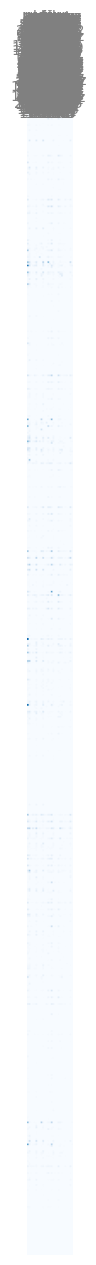

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(len(bi_itos[:50])):
    for j in range(len(si_itos)):
        chstr = bi_itos[i] + si_itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [41]:
len(N[0]) # First bi-character '.a' along 27 characters.
N[0]

tensor([  0, 207, 190,  31, 366,  55,  21,  17,  91, 154,  27,  75, 632, 384,
        623,  10,  17,   9, 482, 194,  72, 152, 243,   6,  27, 173, 152],
       dtype=torch.int32)

In [42]:
# Statistics approach.

p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.0469, 0.0431, 0.0070, 0.0830, 0.0125, 0.0048, 0.0039, 0.0206,
        0.0349, 0.0061, 0.0170, 0.1433, 0.0871, 0.1413, 0.0023, 0.0039, 0.0020,
        0.1093, 0.0440, 0.0163, 0.0345, 0.0551, 0.0014, 0.0061, 0.0392, 0.0345])

In [ ]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

In [ ]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

In [ ]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

In [ ]:
p.shape

In [ ]:
P.shape

In [ ]:
P.sum(1, keepdim=True).shape

In [24]:
# 27, 27
# 27,  1

In [ ]:
P.sum(1).shape

In [26]:
# 27, 27
#  1, 27

In [310]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

In [165]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [ ]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

In [ ]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
xs

In [ ]:
ys

In [ ]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

In [ ]:
xenc.shape

In [ ]:
plt.imshow(xenc)

In [ ]:
xenc.dtype

In [ ]:
W = torch.randn((27, 1))
xenc @ W

In [ ]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

In [ ]:
probs[0]

In [ ]:
probs[0].shape

In [ ]:
probs[0].sum()

In [ ]:
# (5, 27) @ (27, 27) -> (5, 27)

In [ ]:
# SUMMARY ------------------------------>>>>

In [ ]:
xs

In [ ]:
ys

In [557]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [558]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [ ]:
probs.shape

In [ ]:

nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

In [561]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [ ]:
xs

In [ ]:
ys

In [580]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [602]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
print(loss.item())

In [604]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [605]:
W.data += -0.1 * W.grad

In [606]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# gradient descent
for k in range(1):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))